In [1]:
%load_ext autoreload

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

%autoreload 2
from subgrid_parameterization.preprocess.mixing_length import compute_mixing_length
from subgrid_parameterization.preprocess.mixing_length import get_mixing_length
from subgrid_parameterization.preprocess import SAM_helpers as sam

In [3]:
path0 = "/glade/work/stepheba/les_and_clubb_benchmark_runs/stepheba_sam_runs/derecho/"

# path = 'sam-bomex/'
# file = 'BOMEX_64x64x75_100m_40m_1s'
# file = 'BOMEX_3d'

path = "sam-rf01/"
file = "DYCOMS_RF01_96x96x320"
# file = '*_3d'

# # RF01 won't work until stretched grid is implemented
# path = 'sam-rf02/'
# file = 'DYCOMS_RF02_128x128x96_dr_nosed'
# file = '*_3d'

ds = xr.open_dataset(path0 + path + file + ".nc")
# ds=ds.isel(time=slice(-3,-1))
ds

<xarray.Dataset> Size: 135MB
Dimensions:      (x: 1, y: 1, z: 320, time: 240)
Coordinates:
  * x            (x) float32 4B -122.0
  * y            (y) float32 4B 31.5
  * z            (z) float32 1kB 2.5 7.5 12.5 ... 1.588e+03 1.592e+03 1.598e+03
  * time         (time) datetime64[ns] 2kB 2001-07-10T06:01:00 ... 2001-07-10...
Data variables: (12/446)
    p            (z) float32 1kB ...
    PREC         (time) float32 960B ...
    CWP          (time) float32 960B ...
    IWP          (time) float32 960B ...
    RWP          (time) float32 960B ...
    SWP          (time) float32 960B ...
    ...           ...
    THLPRRP_IP   (time, z, y, x) float32 307kB ...
    RTPNRP_IP    (time, z, y, x) float32 307kB ...
    THLPNRP_IP   (time, z, y, x) float32 307kB ...
    RRPNRP_IP    (time, z, y, x) float32 307kB ...
    RRP3_IP      (time, z, y, x) float32 307kB ...
    NRP3_IP      (time, z, y, x) float32 307kB ...
Attributes:
    SAM version:  
    caseid:       96x96x320
    Conventions:  COARDS

In [4]:
# L, Lup, Ldown = get_mixing_length(ds)

In [5]:
# np.mean(L)

In [6]:
# Pass instead of 'grid' object
nzm, nzt, ngrdcol, zm, zt, dzm, dzt, invrs_dzm, invrs_dzt = sam.get_grid(ds)

In [7]:
thvm = sam.stagger_var("THETAV", ds, "zt")
thlm = sam.stagger_var("THETAL", ds, "zt")
rtm = sam.stagger_var("RTM", ds, "zt")

In [8]:
U2 = sam.stagger_var("U2", ds, "zm")
V2 = sam.stagger_var("V2", ds, "zm")
W2 = sam.stagger_var("W2", ds, "zm")
em = 0.5 * (U2 + V2 + W2)

In [9]:
Lscale_max = (
    0.25 * 64 * 100
)  # 64 pts * 100 m dx_LES = dx_GCM, CLUBB takes 1/4 this for max when implemented

In [10]:
p_in_Pa = sam.stagger_var("p", ds, "zt") * 100  # p in mb * 10^-3 bar/mb * 10^5 Pa/bar

In [11]:
cp = 1004.0  # Specific heat capacity of air at constant pressure
Rd = 287.0  # Gas constant for dry air
exner = (
    (p_in_Pa / 10**5) ** (Rd / cp)
)  # Calc as sam.stagger_var('TABS',ds,'zt') / sam.stagger_var('THETA',ds,'zt')  instead?

In [12]:
# thv_ds = sam.stagger_var('THETA',ds,'zt') # Not sure how to get 'base-state' from LES. From *.F90: ! Dry, base-state theta_v on thermodynamic level [K]
thv_ds = sam.stagger_var("THETA", ds, "zt") * (1 + 0.608 * rtm)

In [13]:
# ! mu = (1/M) dM/dz > 0.  mu=0 for no entrainment.
# Siebesma recommends mu=2e-3, although most schemes use mu=1e-4
#     ! When mu was fixed, we used the value mu = 6.e-4
# mu = np.full(ngrdcol,6.e-4) # How to get this as a function varying by column? only if CLUBBND_CAM isdef (normally CLUBB_CAM)
mu = np.full(
    ngrdcol, 1.0e-3
)  # https://github.com/larson-group/clubb_release/blob/15e802092f65b3a20e5d67cb32d40f8a2771ca9b/src/CLUBB_core/parameters_tunable.F90#L234

In [14]:
lmin = 20.0  # (lmin_coeff=0.5)*(lmin_deltaz = 40)

In [15]:
saturation_formula = 1
l_implemented = True

In [16]:
L, Lup, Ldown = compute_mixing_length(
    nzm,
    nzt,
    ngrdcol,
    zm,
    zt,
    dzm,
    dzt,
    invrs_dzm,
    invrs_dzt,
    thvm,
    thlm,
    rtm,
    em,
    Lscale_max,
    p_in_Pa,
    exner,
    thv_ds,
    mu,
    lmin,
    saturation_formula,
    l_implemented,
)

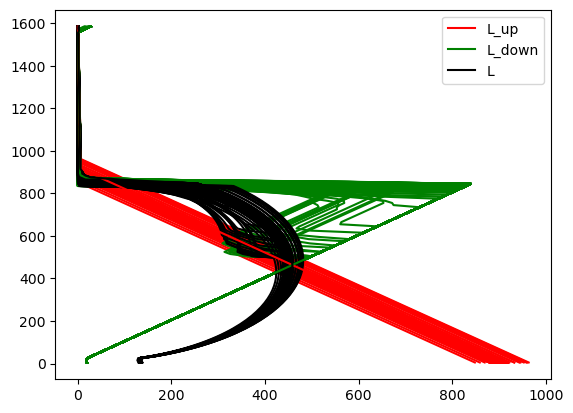

In [17]:
kstart = 0
kend = int(1 * nzm)
plt.plot(Lup[:-1, kstart:kend].T, zt[:-1, kstart:kend].T, "r")
plt.plot(Ldown[:-1, kstart:kend].T, zt[:-1, kstart:kend].T, "g")
plt.plot(L[:-1, kstart:kend].T, zt[:-1, kstart:kend].T, "k")
plt.plot(Lup[-1, kstart:kend].T, zt[-1, kstart:kend].T, "r", label="L_up")
plt.plot(Ldown[-1, kstart:kend].T, zt[-1, kstart:kend].T, "g", label="L_down")
plt.plot(L[-1, kstart:kend].T, zt[-1, kstart:kend].T, "k", label="L")
plt.legend();

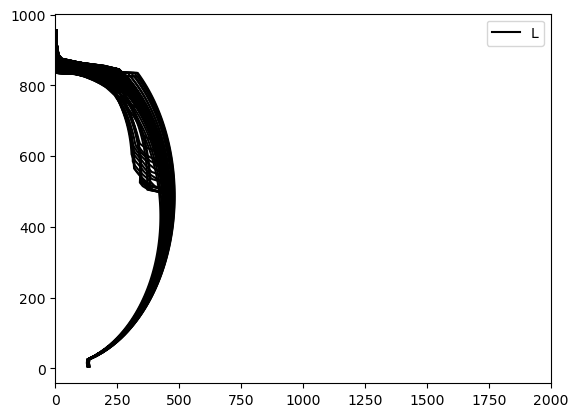

In [18]:
kstart = 0
kend = int(0.6 * nzm)
# plt.plot(Lup[:-1, kstart:kend].T,zt[:-1, kstart:kend].T,'r')
# plt.plot(Ldown[:-1, kstart:kend].T, zt[:-1, kstart:kend].T, "g")
plt.plot(L[:-1, kstart:kend].T, zt[:-1, kstart:kend].T, "k")
# plt.plot(Lup[-1, kstart:kend].T,zt[-1, kstart:kend].T,'r',label='L_up')
# plt.plot(Ldown[-1, kstart:kend].T, zt[-1, kstart:kend].T, "g", label="L_down")
plt.plot(L[-1, kstart:kend].T, zt[-1, kstart:kend].T, "k", label="L")
plt.xlim([0, 2000])
plt.legend();

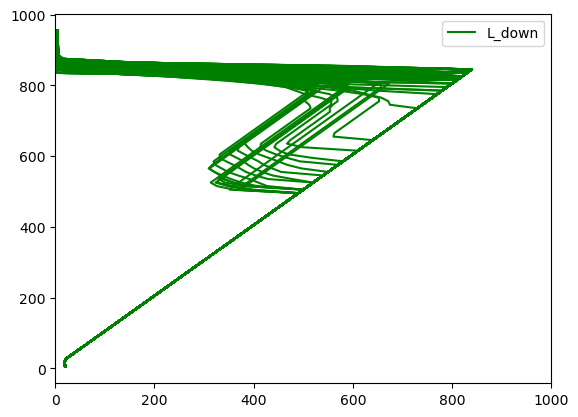

In [19]:
kstart = 0
kend = int(0.6 * nzm)
# plt.plot(Lup[:-1, kstart:kend].T,zt[:-1, kstart:kend].T,'r')
plt.plot(Ldown[:-1, kstart:kend].T, zt[:-1, kstart:kend].T, "g")
# plt.plot(L[:-1, kstart:kend].T,zt[:-1, kstart:kend].T,'k');
# plt.plot(Lup[-1, kstart:kend].T,zt[-1, kstart:kend].T,'r',label='L_up')
plt.plot(Ldown[-1, kstart:kend].T, zt[-1, kstart:kend].T, "g", label="L_down")
# plt.plot(L[-1, kstart:kend].T,zt[-1, kstart:kend].T,'k',label='L');
plt.xlim([0, 1000])
plt.legend();